In [1]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

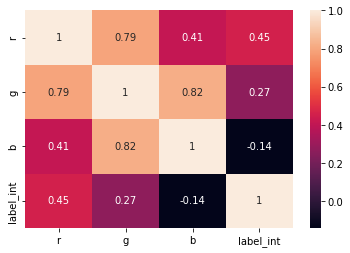

In [4]:
import pandas as pd
df = pd.read_csv(r"./csv/full/all.csv", encoding="utf-8-sig", delimiter=',', thousands=r',', dtype=None, chunksize=None)
df.head()

X = df.drop(columns=['label','label_int'])
y = df['label_int']

import matplotlib.pyplot as plt
import seaborn as sns
corr_mat = df.corr()
sns.heatmap(corr_mat, annot=True)
plt.show()

# Stacking
#### https://viblo.asia/p/lam-chu-stacking-ensemble-learning-Az45b0A6ZxY
![](2022-03-23-01-00-38.png)
#### https://towardsdatascience.com/stacking-classifier-approach-for-a-multi-classification-problem-56f3d5e120c8#:~:text=A%20stacking%20classifier%20is%20an,task%20of%20the%20final%20classification.&text=The%20stacking%20classifier%20approach%20can,implement%20a%20multi%2Dclassification%20problem.
![](2022-03-23-11-27-21.png)

PCA
PCA, KNN and SVM needs feature scaling!
Naive Bayes, Decision Tree, Random Forest and XGBoost do not!

[0.78756411 0.1969676 ]


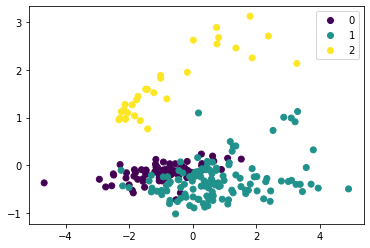

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)
# print(X_pca)

# values = [0, 0, 1, 2, 2, 2]
# colors = ListedColormap(['r','b','g'])
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.legend(handles=scatter.legend_elements()[0], labels=[0,1,2])

In [6]:
from sklearn.model_selection import train_test_split
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)

Fitting 10 folds for each of 199 candidates, totalling 1990 fits
accuracy = 0.8043478260869565
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.87      0.77      0.82        26
           2       1.00      1.00      1.00         8

    accuracy                           0.80        46
   macro avg       0.82      0.84      0.83        46
weighted avg       0.82      0.80      0.81        46

KNeighborsClassifier()
lowest RMSE = 0.37619206243122316


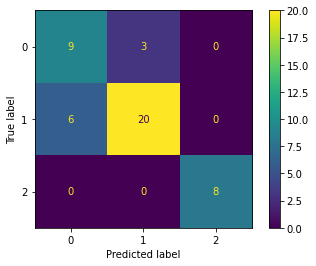

In [12]:
import shutup
shutup.please()


from sklearn.neighbors import KNeighborsClassifier
import numpy as np
knn_clf = KNeighborsClassifier()
param_grid = {
    "n_neighbors": np.arange(1, 200, 1)
}
knn_clf_lowest_mse = GridSearchCV(knn_clf, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
knn_clf_lowest_mse.fit(X_pca_train, y_train)


from sklearn import metrics
y_pred = knn_clf_lowest_mse.predict(X_pca_test)
print('accuracy =', metrics.accuracy_score(y_test, y_pred))


from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(knn_clf_lowest_mse, X_pca_test, y_test)  
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))


from numpy import average, median
print(knn_clf_lowest_mse.best_estimator_)
rmse_lowest = (-knn_clf_lowest_mse.best_score_)**(1/2.0)
print("lowest RMSE =", rmse_lowest)

#### Confusion Matrix
https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
accuracy = 0.8913043478260869
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.92      0.88      0.90        26
           2       1.00      1.00      1.00         8

    accuracy                           0.89        46
   macro avg       0.90      0.91      0.90        46
weighted avg       0.89      0.89      0.89        46

SVC(C=10000.0, gamma=0.1)
lowest RMSE = 0.3529325764346102


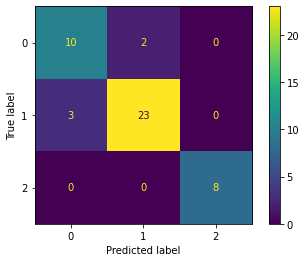

In [8]:
import shutup
shutup.please()


from sklearn.svm import SVC
import numpy as np
svc = SVC()
param_grid = {
    'kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 
    'C': [np.float_power(10, i) for i in np.arange(-5, 5, 1)],
    'gamma': [np.float_power(10, i) for i in np.arange(0, -5, -1)],
    # 'epsilon': [0.07, 0.085]
}
svc_lowest_mse = GridSearchCV(svc, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
svc_lowest_mse.fit(X_pca_train, y_train)


from sklearn import metrics
y_pred = svc_lowest_mse.predict(X_pca_test)
print('accuracy =', metrics.accuracy_score(y_test, y_pred))


from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(svc_lowest_mse, X_pca_test, y_test)  
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))


from numpy import average, median
print(svc_lowest_mse.best_estimator_)
rmse_lowest = (-svc_lowest_mse.best_score_)**(1/2.0)
print("lowest RMSE =", rmse_lowest)



In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('svc', SVC()),
    ('knn_clf', KNeighborsClassifier())
]

sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

params = {
    'svc__kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 
    'svc__C': [np.float_power(10, i) for i in np.arange(-5, 5, 1)],
    'svc__gamma': [np.float_power(10, i) for i in np.arange(0, -5, -1)],
    'knn_clf__n_neighbors': np.arange(5, 10, 1)
}

grid_lowest_mse = GridSearchCV(estimator=sclf, param_grid=params, scoring='neg_mean_squared_error', verbose=1, cv=10, n_jobs=-1)
grid_lowest_mse.fit(X_pca_train, y_train)


print(grid_lowest_mse.best_estimator_)
from sklearn import metrics
y_pred = grid_lowest_mse.predict(X_pca_test)
print('accuracy =', metrics.accuracy_score(y_test, y_pred))

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
from sklearn.naive_bayes import CategoricalNB
catnb_clf = CategoricalNB()
catnb_clf.fit(X_train, y_train)
y_pred = catnb_clf.predict(X_test)

from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_test, y_pred))

accuracy = 0.5652173913043478


In [32]:
from sklearn.naive_bayes import MultinomialNB
mnnb_clf = MultinomialNB()
mnnb_clf.fit(X_train, y_train)
y_pred = mnnb_clf.predict(X_test)

from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_test, y_pred))

accuracy = 0.782608695652174


In [30]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
y_pred = gnb_clf.predict(X_test)

from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_test, y_pred))

accuracy = 0.6739130434782609


Fitting 10 folds for each of 50 candidates, totalling 500 fits
DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
accuracy = 0.8913043478260869
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.92      0.88      0.90        26
           2       1.00      1.00      1.00         8

    accuracy                           0.89        46
   macro avg       0.90      0.91      0.90        46
weighted avg       0.89      0.89      0.89        46



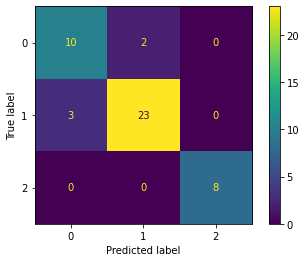

In [35]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import shutup
shutup.please()

dt_clf = DecisionTreeClassifier()
param_grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
dt_clf_lowest_mse = GridSearchCV(dt_clf, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
dt_clf_lowest_mse.fit(X_pca_train, y_train)
print(dt_clf_lowest_mse.best_estimator_)

from sklearn import metrics
y_pred = dt_clf_lowest_mse.predict(X_pca_test)
print('accuracy =', metrics.accuracy_score(y_test, y_pred))


from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(dt_clf_lowest_mse, X_pca_test, y_test)  
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))


In [36]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('svc', SVC(C=10000.0, gamma=0.1)),
    ('dt_clf', DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)),
    
]

sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
sclf.fit(X_pca_train, y_train)
y_pred = sclf.predict(X_pca_test)


from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_test, y_pred))

accuracy = 0.8913043478260869


In [39]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('svc', SVC()),
    ('dt_clf', DecisionTreeClassifier()),
    # ('knn_clf', KNeighborsClassifier())
]

sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
sclf.fit(X_pca_train, y_train)
y_pred = sclf.predict(X_pca_test)


from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_test, y_pred))

accuracy = 0.8695652173913043


In [ ]:
from sklearn.tree import Random
import numpy as np
import shutup
shutup.please()

dt_clf = DecisionTreeClassifier()
param_grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
dt_clf_lowest_mse = GridSearchCV(dt_clf, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
dt_clf_lowest_mse.fit(X_pca_train, y_train)
print(dt_clf_lowest_mse.best_estimator_)

from sklearn import metrics
y_pred = dt_clf_lowest_mse.predict(X_pca_test)
print('accuracy =', metrics.accuracy_score(y_test, y_pred))


from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(dt_clf_lowest_mse, X_pca_test, y_test)  
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))


In [40]:
import dill
dill.dump_session('sessions/classifier.pkl')

In [1]:
import dill
dill.load_session('sessions/classifier.pkl')